In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq


In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the text data with utf-8 encoding
path = '1661-0.txt'
with open(path, encoding='utf-8') as f:
    text = f.read().lower()

print('Original corpus length:', len(text))

# Remove punctuation, numbers, and special characters
text = re.sub(r'[^a-z\s]', '', text)
print('Cleaned corpus length:', len(text))

# Tokenize the text
tokens = word_tokenize(text)
print('Number of tokens:', len(tokens))

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]
print('Number of tokens after stopwords removal:', len(tokens))

# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(word) for word in tokens]
print('Number of tokens after lemmatization:', len(tokens))

# Rejoin tokens into a single string
cleaned_text = ' '.join(tokens)
print('Cleaned corpus length:', len(cleaned_text))

# Save the cleaned text to a new file
with open('cleaned_text.txt', 'w', encoding='utf-8') as f:
    f.write(cleaned_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chidvilash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chidvilash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chidvilash\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original corpus length: 581888
Cleaned corpus length: 557889
Number of tokens: 107485
Number of tokens after stopwords removal: 48327
Number of tokens after lemmatization: 48327
Cleaned corpus length: 326420


In [3]:
# Get the unique words and their indices
unique_words = np.unique(tokens)
unique_word_index = {word: idx for idx, word in enumerate(unique_words)}

print('Unique words:', len(unique_words))
print('Unique word index:', unique_word_index)

# Rejoin tokens into a single string
cleaned_text = ' '.join(tokens)
print('Cleaned corpus length:', len(cleaned_text))

# Save the cleaned text to a new file
with open('cleaned_text.txt', 'w', encoding='utf-8') as f:
    f.write(cleaned_text)

Unique words: 7695
Unique word index: {'abandon': 0, 'abandoned': 1, 'abbot': 2, 'aberdeen': 3, 'abhorrent': 4, 'abide': 5, 'abjure': 6, 'able': 7, 'abnormal': 8, 'abnormally': 9, 'abode': 10, 'abominable': 11, 'abomination': 12, 'abound': 13, 'abroad': 14, 'abrupt': 15, 'abruptly': 16, 'absence': 17, 'absent': 18, 'absolute': 19, 'absolutely': 20, 'absolved': 21, 'absorb': 22, 'absorbed': 23, 'absorbing': 24, 'abstracted': 25, 'absurd': 26, 'absurdly': 27, 'abuse': 28, 'abusive': 29, 'abutted': 30, 'accent': 31, 'accept': 32, 'acceptance': 33, 'accepted': 34, 'accepting': 35, 'access': 36, 'accessed': 37, 'accessible': 38, 'accessory': 39, 'accident': 40, 'accidental': 41, 'accommodate': 42, 'accompanied': 43, 'accompany': 44, 'accompanying': 45, 'accompli': 46, 'accomplice': 47, 'accomplish': 48, 'accomplished': 49, 'accomplishment': 50, 'accordance': 51, 'according': 52, 'account': 53, 'accountant': 54, 'accumulated': 55, 'accumulation': 56, 'accurate': 57, 'accurately': 58, 'accuse

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(tokens) - WORD_LENGTH):
    prev_words.append(tokens[i:i + WORD_LENGTH])
    next_words.append(tokens[i + WORD_LENGTH])

# Print sample sequences
print('Sample previous words:', prev_words[0])
print('Sample next word:', next_words[0])

# Convert words to their corresponding indices
prev_word_indices = [[unique_word_index[word] for word in seq] for seq in prev_words]
next_word_indices = [unique_word_index[word] for word in next_words]

# Convert to numpy arrays
X = np.array(prev_word_indices)
y = np.array(next_word_indices)

# Padding sequences (if necessary)
X_padded = pad_sequences(X, maxlen=WORD_LENGTH, padding='pre')
print('Shape of X:', X_padded.shape)
print('Shape of y:', y.shape)

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

print('Training set size:', X_train.shape)
print('Validation set size:', X_val.shape)

Sample previous words: ['project', 'gutenberg', 'adventure', 'sherlock', 'holmes']
Sample next word: arthur
Shape of X: (48322, 5)
Shape of y: (48322,)
Training set size: (38657, 5)
Validation set size: (9665, 5)


In [5]:
# Create a 3D NumPy array `X` of shape (number of sequences, sequence length, vocabulary size) initialized with False (boolean type)
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
# Create a 2D NumPy array `Y` of shape (number of sequences, vocabulary size) initialized with False (boolean type)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
# Loop through each sequence in `prev_words`
for i, each_words in enumerate(prev_words):
    # Loop through each word in the sequence
    for j, each_word in enumerate(each_words):
        # Set the appropriate position in the 3D array `X` to True
        # `i` is the index of the sequence, `j` is the index of the word in the sequence, 
        # `unique_word_index[each_word]` is the index of the word in the vocabulary
        X[i, j, unique_word_index[each_word]] = 1
    # Set the appropriate position in the 2D array `Y` to True
    # `i` is the index of the sequence, `unique_word_index[next_words[i]]` is the index of the next word in the vocabulary
    Y[i, unique_word_index[next_words[i]]] = 1


In [6]:
print(X[0][0])

[False False False ... False False False]


In [8]:
from keras.models import Model
from keras.layers import LSTM, Dense, Activation, Input, Embedding, Dropout, Bidirectional
from keras.optimizers import RMSprop, Adam
import pickle

# Define the input shape
input_shape = (WORD_LENGTH,)
vocab_size = len(unique_words)

# Create the model using the Functional API
inputs = Input(shape=input_shape)
x = Embedding(input_dim=vocab_size, output_dim=300, trainable=False)(inputs)  # Use pre-trained embeddings
x = Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer='l2'))(x)
x = Dropout(0.3)(x)
x = LSTM(256, kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dense(vocab_size)(x)
outputs = Activation('softmax')(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Change optimizer and learning rate
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=128)

# Save the model and training history
model.save('keras_next_word_model.keras')
pickle.dump(history.history, open("history.p", "wb"))

# Access the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print(f"Final Training Accuracy: {training_accuracy[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracy[-1] * 100:.2f}%")

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(X_val, y_val, batch_size=128)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 5, 300)         │     2,308,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 5, 512)         │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7695)           │     1,977,615 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 7695)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,280,099 (23.96 MB)

 Trainable params: 3,971,599 (15.15 MB)

 Non-trainable params: 2,308,500 (8.81 MB)

Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 69s 187ms/step - accuracy: 0.0103 - loss: 12.4611 - val_accuracy: 0.0099 - val_loss: 8.0104
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.0090 - loss: 7.7920 - val_accuracy: 0.0099 - val_loss: 8.0717
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 52s 173ms/step - accuracy: 0.0085 - loss: 7.7579 - val_accuracy: 0.0099 - val_loss: 8.0452
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 52s 173ms/step - accuracy: 0.0096 - loss: 7.7520 - val_accuracy: 0.0099 - val_loss: 8.0616
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.0091 - loss: 7.7342 - val_accuracy: 0.0099 - val_loss: 8.0974
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 55s 181ms/step - accuracy: 0.0091 - loss: 7.7495 - val_accuracy: 0.0093 - val_loss: 8.1111
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 53s 174ms/step - accuracy: 0.0094 - loss: 7.7256 - val_accuracy: 0.0099 - val_loss: 8.1274
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 53s 173ms/step - accuracy: 0.0099 - loss: 7.

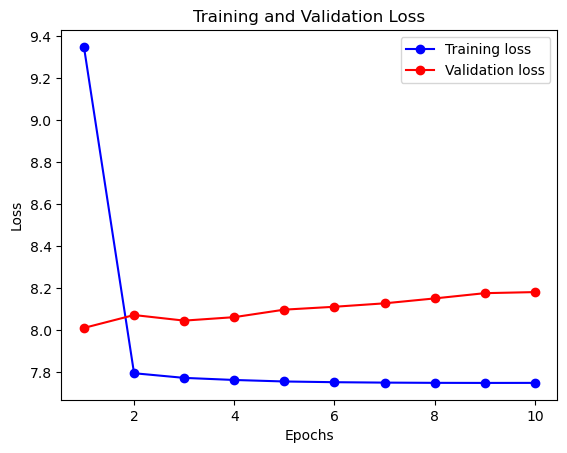

In [9]:
import matplotlib.pyplot as plt

# Assuming history is loaded or defined properly
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [1]:
import numpy as np
import heapq
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define constants and variables
SEQUENCE_LENGTH = 40
chars = set("abcdefghijklmnopqrstuvwxyz ")
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

unique_words = set(word for quote in quotes for word in quote.lower().split())
unique_word_index = {word: i for i, word in enumerate(unique_words)}
max_sequence_length = 10

def prepare_input(text, unique_word_index, max_sequence_length):
    words = text.split()[:max_sequence_length]  # Limit the number of words to max_sequence_length
    x = np.zeros((1, max_sequence_length, 1))  # Note the additional dimension for the LSTM layer
    
    for i, word in enumerate(words):
        if word in unique_word_index:
            x[0, i, 0] = unique_word_index[word]
        else:
            x[0, i, 0] = len(unique_word_index)  # Out of vocabulary token index
    
    return x

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text, unique_word_index, max_sequence_length)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == "'":
            return completion

def predict_completions(text, n=3):
    x = prepare_input(text, unique_word_index, max_sequence_length)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char.get(idx, '?') for idx in next_indices]

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(max_sequence_length, 1)))  # Note the input_shape correction
model.add(Dense(len(unique_words), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Train the model
for q in quotes:
    seq = q[:40].lower()
    words = seq.split()
    if words[-1] in unique_word_index:
        x = prepare_input(seq, unique_word_index, max_sequence_length)
        y = np.zeros((1, len(unique_words)))
        y[0, unique_word_index[words[-1]]] = 1
        model.fit(x, y, epochs=1, verbose=0)

# Test the model
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

C:\Users\Chidvilash\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


it is not a lack of love, but a lack of 
['b', 'q', '?', 't', 'l']

that which does not kill us makes us str
['b', 'g', '?', '?', '?']

i'm not upset that you lied to me, i'm u
['q', 'b', 'i', '?', 't']

and those who were seen dancing were tho
['b', '?', 'g', 't', '?']

it is hard enough to remember my opinion
['?', 'b', 'g', 't', '?']

